# Cleaning up 311 Service Request Data

In this jupyter notebook we will explore the datasets used for our project. We will primarily focus on


In [1]:
![ -f ../requirements.txt ] && pip install -r ../requirements.txt -q || pip install -r ./requirements.txt -q

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from census import Census
import os

if os.getcwd().endswith("notebooks"):
    os.chdir("../")
print("Current working directory:", os.getcwd())

# Loading environment variables
from dotenv import load_dotenv

load_dotenv()
CENSUS_API_KEY = os.getenv("CENSUS_API_KEY")

Current working directory: /home/manpazito/projects/class-materials/CY PLAN 101/311-neighborhood-equity


## 311 Cases in 2023

Below is the raw table of all 311 service requests opened in 2023.


In [3]:
serv_req_df = pd.read_csv("data/raw/311_Cases_2023.csv")

Let's do a quick analysis of what this dataset consists of.


In [4]:
serv_req_df.sample(5)

,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,...,Police District,Latitude,Longitude,Point,point_geom,Source,Media URL,BOS_2012,data_as_of,data_loaded_at
239265,17257612,09/05/2023 09:33:15 AM,NaN,11/05/2023 10:30:16 AM,Open,open,DPW Ops Queue,Graffiti,Graffiti on Building_other,Building_other - Not_Offensive,...,MISSION,37.764941,-122.423540,"(37.76494137, -122.42354038)",POINT (-122.42354038 37.76494137),Integrated Agency,NaN,NaN,2024/04/10 10:23:00 AM,2024/09/11 05:09:50 PM
162966,17532089,11/09/2023 04:37:00 PM,11/09/2023 08:45:00 PM,11/09/2023 08:45:00 PM,Closed,Case is a Duplicate,DPW Ops Queue,Illegal Postings,Illegal Postings - Posted_on_Traffic_Light,Posted on Traffic Light,...,MISSION,37.767819,-122.428388,"(37.76781869, -122.42838758)",POINT (-122.428387579 37.76781869),Mobile/Open311,NaN,NaN,2024/04/10 10:23:00 AM,2024/09/11 05:09:50 PM
71609,17227729,08/28/2023 05:23:27 PM,08/29/2023 06:01:59 PM,08/29/2023 06:01:59 PM,Closed,Case Resolved - Pickup completed,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,...,MISSION,37.751075,-122.412828,"(37.751075, -122.41282833)",POINT (-122.412828333 37.751075),Mobile/Open311,NaN,9.0,2024/02/20 10:35:55 AM,2024/09/11 05:09:50 PM
5818,17140646,08/08/2023 12:05:00 PM,08/11/2023 02:30:33 AM,08/11/2023 02:30:33 AM,Closed,Case Resolved - EAM Case 12168 update,DPT SignShop Queue,Graffiti,Graffiti on Other_enter_additional_details_below,Other_enter_additional_details_below - Offensive,...,RICHMOND,37.780885,-122.464419,"(37.78088538, -122.46441943)",POINT (-122.464419428 37.780885379),Web,NaN,1.0,2024/02/20 10:35:55 AM,2024/09/11 05:09:50 PM
363774,16636225,04/06/2023 06:53:00 AM,04/06/2023 08:07:47 AM,04/06/2023 08:07:47 AM,Closed,Case Resolved - Investigated by SFMTA - Action...,SFMTA - Access/Mobility Services Received Queue,General Request - MTA,request_for_service,scooters - request_for_service,...,MISSION,37.752658,-122.418290,"(37.7526578, -122.4182895)",POINT (-122.4182895 37.7526578),Web,NaN,9.0,2024/02/20 10:35:55 AM,2024/09/11 05:09:50 PM


In [5]:
print(serv_req_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840206 entries, 0 to 840205
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CaseID                 840206 non-null  int64  
 1   Opened                 840206 non-null  object 
 2   Closed                 808740 non-null  object 
 3   Updated                840206 non-null  object 
 4   Status                 840206 non-null  object 
 5   Status Notes           835836 non-null  object 
 6   Responsible Agency     840206 non-null  object 
 7   Category               840206 non-null  object 
 8   Request Type           840206 non-null  object 
 9   Request Details        831141 non-null  object 
 10  Address                840206 non-null  object 
 11  Street                 830788 non-null  object 
 12  Supervisor District    830788 non-null  float64
 13  Neighborhood           830704 non-null  object 
 14  Analysis Neighborhood  732571 non-nu

## Cleaning the Service Requests DataFrame

### Initial Cleanup


In [6]:
# Selecting useful columns
useful_cols = [
    "CaseID",
    "Opened",
    "Closed",
    "Updated",
    "Status",
    "Status Notes",
    "Responsible Agency",
    "Category",
    "Request Type",
    "Request Details",
    "Neighborhood",
    "Analysis Neighborhood",
    "Police District",
    "Latitude",
    "Longitude",
    "Source",
]

serv_req_df = serv_req_df[useful_cols].copy()

# Removing duplicates and filtering by SF bounding box
serv_req_df.drop_duplicates(subset="CaseID", inplace=True)
serv_req_df = serv_req_df[
    serv_req_df["Latitude"].between(37.6, 37.9)
    & serv_req_df["Longitude"].between(-123.2, -122.3)
]

# Simplifying column names
serv_req_df.columns = serv_req_df.columns.str.strip().str.lower().str.replace(" ", "_")

print("DataFrame snippet so far:\n")
display(serv_req_df.sample(3))

DataFrame snippet so far:



,caseid,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,neighborhood,analysis_neighborhood,police_district,latitude,longitude,source
225889,16373836,02/01/2023 05:04:00 AM,02/06/2023 12:32:38 PM,02/06/2023 12:32:38 PM,Closed,Case Resolved,DPW Ops Queue,Litter Receptacles,Toters_left_out_24x7,NaN,Marina,Marina,NORTHERN,37.803112,-122.427225,Web
2569,17297368,09/14/2023 10:12:16 AM,09/14/2023 10:35:00 AM,09/14/2023 10:35:00 AM,Closed,Comment Noted,RPD NSA Queue,Illegal Postings,Illegal Postings - Affixed_Improperly,Affixed Improperly,Golden Gate Park,Golden Gate Park,PARK,37.768163,-122.453573,Mobile/Open311
788537,16443205,02/17/2023 07:15:00 PM,02/17/2023 10:57:19 PM,02/17/2023 10:57:19 PM,Closed,Case Resolved - Officer responded to request u...,Parking Enforcement Dispatch Queue,Parking Enforcement,Other_Illegal_Parking,Silver - Toyota Corolla - 8SSW229,Excelsior,Excelsior,INGLESIDE,37.721659,-122.428453,Web


### Categorizing Categoricals

We're just marking a column if they're a categorical or not.


In [7]:
cat_cols = [
    "status",
    "status_notes",
    "responsible_agency",
    "category",
    "request_type",
    "request_details",
    "neighborhood",
    "analysis_neighborhood",
    "police_district",
    "source",
]

for col in cat_cols:
    if col in serv_req_df.columns:
        serv_req_df[col] = (
            serv_req_df[col]
            .astype("string")  # efficient string dtype
            .str.strip()  # remove leading/trailing spaces
            .str.replace(r"\s+", " ", regex=True)  # collapse multiple spaces
            .str.replace("_", " ", regex=False)  # underscores → spaces
            .str.title()  # nice display casing
        )

### Temporal Cleanup


In [8]:
# Properly format date columns
date_cols = ["opened", "closed", "updated"]

for col in date_cols:
    serv_req_df[col] = pd.to_datetime(
        serv_req_df[col], format="%m/%d/%Y %I:%M:%S %p", errors="coerce"
    )

# Ensure no nan and in 2023 range
serv_req_df = serv_req_df.dropna(subset=["opened", "closed"])
serv_req_df = serv_req_df[
    (serv_req_df["opened"].dt.year == 2023) & (serv_req_df["closed"].dt.year == 2023)
]

# Deriving new temporal columns
serv_req_df["year"] = serv_req_df["opened"].dt.year.astype("Int16")
serv_req_df["month"] = serv_req_df["opened"].dt.month.astype("Int8")
serv_req_df["dow"] = serv_req_df["opened"].dt.day_name()
serv_req_df["hour"] = serv_req_df["opened"].dt.hour.astype("Int8")
serv_req_df["request_duration_hrs"] = (
    serv_req_df["closed"] - serv_req_df["opened"]
).dt.total_seconds() / 3600

### Spatial Cleanup


In [9]:
# points (WGS84)
serv_req_gdf = gpd.GeoDataFrame(
    serv_req_df.dropna(subset=["longitude", "latitude"]).copy(),
    geometry=gpd.points_from_xy(serv_req_df.longitude, serv_req_df.latitude),
    crs="EPSG:4326",
)

sf_tracts_gdf = gpd.read_file("data/processed/sf_tracts_cleaned_2023.gpkg")

# match CRS
sf_tracts_gdf = sf_tracts_gdf.to_crs(serv_req_gdf.crs)

# keep ONLY points inside tracts (+ add GEOID)
serv_req_gdf = gpd.sjoin(
    serv_req_gdf,
    sf_tracts_gdf[["GEOID", "geometry"]],
    how="inner",
    predicate="intersects",
).drop(columns=["index_right"])

### Some final touches

Some final touches to make sure each column is the right data type.


In [10]:
serv_req_gdf["neighborhood"] = (
    serv_req_gdf["analysis_neighborhood"]
    .fillna(serv_req_gdf["neighborhood"])
    .str.strip()
    .str.title()
)
serv_req_gdf.drop(columns=["analysis_neighborhood"], inplace=True)

serv_req_gdf["category"] = serv_req_gdf["category"].str.title().str.strip()
serv_req_gdf["responsible_agency"] = (
    serv_req_gdf["responsible_agency"].str.replace("_", " ").str.title()
)

serv_req_gdf["is_closed"] = serv_req_gdf["status"].eq("Closed").astype("bool")

bins = [0, 1, 24, 72, np.inf]
labels = ["<1hr", "1–24hr", "1–3days", ">3days"]
serv_req_gdf["response_time_cat"] = pd.cut(
    serv_req_gdf["request_duration_hrs"], bins=bins, labels=labels
)

# A preview of the cleaned GeoDataFrame
display(serv_req_gdf.sample(3))
print("Updated column data types:\n", serv_req_gdf.dtypes)

,caseid,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,...,source,year,month,dow,hour,request_duration_hrs,geometry,GEOID,is_closed,response_time_cat
738728,16990097,2023-07-02 15:27:20,2023-07-10 00:00:00,2023-07-10 00:00:00,Closed,Case Resolved - 7.10.23. No Condition Found At...,Dpw Bsm Queue,Sidewalk Or Curb,Sidewalk Defect,Collapsed Sidewalk,...,Mobile/Open311,2023,7,Sunday,15,176.544444,POINT (-122.47615 37.73046),06075033201,True,>3days
756541,16898165,2023-06-10 12:10:00,2023-09-28 13:42:15,2023-09-28 13:42:15,Closed,Case Resolved - Thanks For Your 311! We Really...,Rpd Ggp Queue,Rec And Park Requests,Park - Structural Maintenance,Graffiti,...,Mobile/Open311,2023,6,Saturday,12,2641.537500,POINT (-122.44703 37.76037),06075030102,True,>3days
731874,17090185,2023-07-26 19:43:33,2023-07-27 16:09:07,2023-07-27 16:09:07,Closed,Case Resolved - Pickup Completed,Recology Overflowing,Street And Sidewalk Cleaning,City Garbage Can Overflowing,City Garbage Can Overflowing,...,Mobile/Open311,2023,7,Wednesday,19,20.426111,POINT (-122.43358 37.77835),06075015802,True,1–24hr


Updated column data types:
 caseid                           int64
opened                  datetime64[ns]
closed                  datetime64[ns]
updated                 datetime64[ns]
status                  string[python]
status_notes            string[python]
responsible_agency      string[python]
category                string[python]
request_type            string[python]
request_details         string[python]
neighborhood            string[python]
police_district         string[python]
latitude                       float64
longitude                      float64
source                  string[python]
year                             Int16
month                             Int8
dow                             object
hour                              Int8
request_duration_hrs           float64
geometry                      geometry
GEOID                           object
is_closed                         bool
response_time_cat             category
dtype: object


### Simple Plot


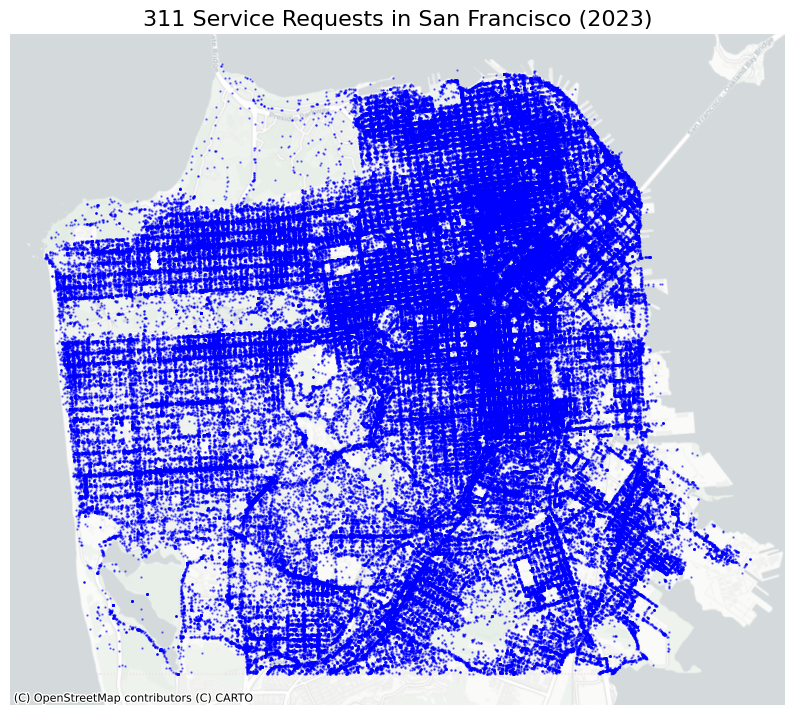

In [11]:
# Plot a simple visualization of the points
fig, ax = plt.subplots(figsize=(10, 10))
serv_req_gdf.plot(ax=ax, markersize=0.5, color="blue", alpha=0.5)
ax.set_title("311 Service Requests in San Francisco (2023)", fontsize=16)
# Overlay a basemap for context (optional)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=serv_req_gdf.crs)
ax.axis("off")
plt.show()

### Quick Dashboard Describing Data


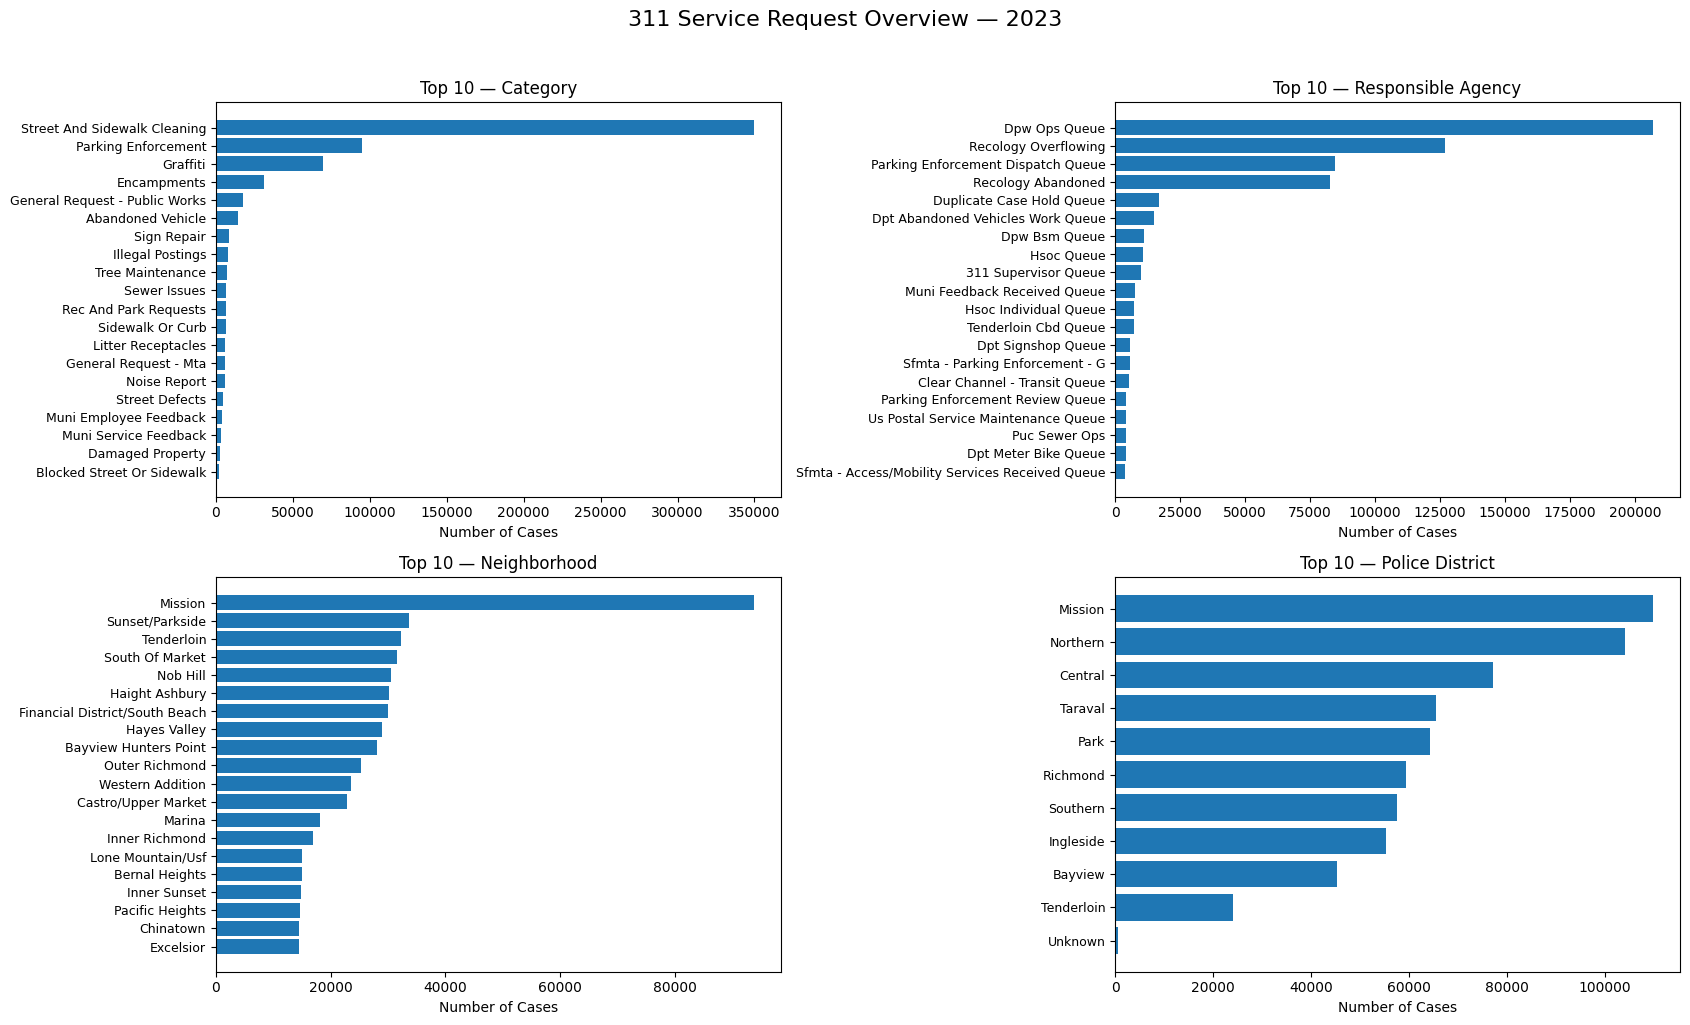

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(17, 10))
axes = axes.flatten()

cat_info = [
    ("category", "Top 10 — Category"),
    ("responsible_agency", "Top 10 — Responsible Agency"),
    ("neighborhood", "Top 10 — Neighborhood"),
    ("police_district", "Top 10 — Police District"),
]

for ax, (col, title) in zip(axes, cat_info):
    if col in serv_req_gdf.columns:
        vc = (
            serv_req_gdf[col]
            .fillna("Unknown")
            .value_counts()
            .nlargest(20)
            .sort_values()
        )
        ax.barh(vc.index, vc.values)
        ax.set_title(title, fontsize=12)
        ax.set_xlabel("Number of Cases")
        ax.tick_params(axis="y", labelsize=9)
    else:
        ax.text(0.5, 0.5, f"{col} not found", ha="center", va="center")
        ax.set_axis_off()

plt.suptitle("311 Service Request Overview — 2023", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

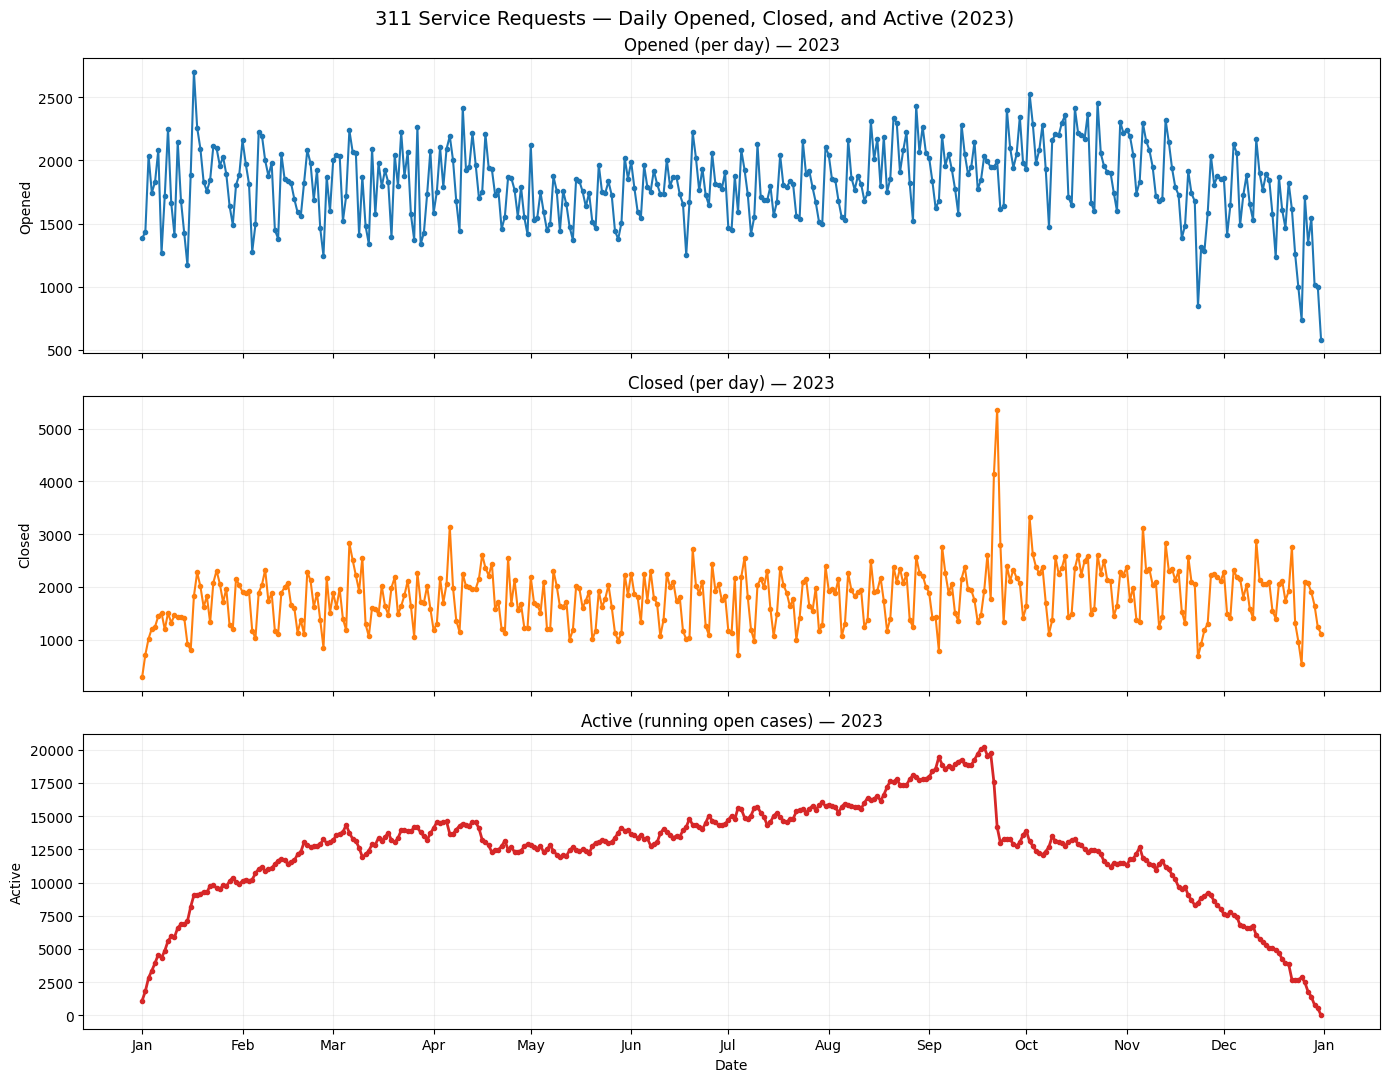

,all_cases,closed_cases,active_end_of_month
month,,,
2023-01-01,56516,56516,0
2023-02-01,49891,49891,0
2023-03-01,56139,56139,0
2023-04-01,54932,54932,0
2023-05-01,51809,51809,0
2023-06-01,54116,54116,0
2023-07-01,54217,54217,0
2023-08-01,60485,60485,0
2023-09-01,58552,58552,0


In [13]:
import matplotlib.dates as mdates

# Ensure datetime and filter to 2023
df = serv_req_gdf.copy()
df["opened"] = pd.to_datetime(df["opened"], errors="coerce")
df["closed"] = pd.to_datetime(df["closed"], errors="coerce")

# Keep records with at least one of opened/closed in 2023
df_2023 = df[(df["opened"].dt.year == 2023) | (df["closed"].dt.year == 2023)].copy()

if df_2023.empty:
    print("No records with opened/closed year == 2023 found.")
else:
    # daily opened/closed counts (timestamped at midnight)
    df_2023["open_day"] = df_2023["opened"].dt.floor("D")
    df_2023["close_day"] = df_2023["closed"].dt.floor("D")

    opened_daily = df_2023.groupby("open_day").size().sort_index()
    closed_daily = df_2023.groupby("close_day").size().sort_index()

    # continuous date index for all days of 2023
    all_days = pd.date_range("2023-01-01", "2023-12-31", freq="D")
    opened_daily = opened_daily.reindex(all_days, fill_value=0)
    closed_daily = closed_daily.reindex(all_days, fill_value=0)

    # cumulative sums
    opened_cum = opened_daily.cumsum()
    closed_cum = closed_daily.cumsum()

    # active backlog = cumulative opened - cumulative closed
    active_daily = opened_cum - closed_cum

    # --- Subplots: separate stacked plots for opened, closed, and active ---
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 11), sharex=True)
    ax_open, ax_closed, ax_active = axes

    # Opened (per day)
    ax_open.plot(
        all_days,
        opened_daily,
        color="tab:blue",
        linewidth=1.5,
        marker="o",
        markersize=3,
    )
    ax_open.set_title("Opened (per day) — 2023")
    ax_open.set_ylabel("Opened")
    ax_open.grid(alpha=0.2)

    # Closed (per day)
    ax_closed.plot(
        all_days,
        closed_daily,
        color="tab:orange",
        linewidth=1.5,
        marker="o",
        markersize=3,
    )
    ax_closed.set_title("Closed (per day) — 2023")
    ax_closed.set_ylabel("Closed")
    ax_closed.grid(alpha=0.2)

    # Active (running open cases)
    ax_active.plot(
        all_days, active_daily, color="tab:red", linewidth=2, marker="o", markersize=3
    )
    ax_active.set_title("Active (running open cases) — 2023")
    ax_active.set_ylabel("Active")
    ax_active.set_xlabel("Date")
    ax_active.grid(alpha=0.2)

    # X axis formatting (months)
    ax_active.xaxis.set_major_locator(mdates.MonthLocator())
    ax_active.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

    plt.suptitle(
        "311 Service Requests — Daily Opened, Closed, and Active (2023)",
        fontsize=14,
        y=0.98,
    )
    plt.tight_layout()
    plt.show()

    # --- Monthly summary table (all, closed, active at month-end) ---
    df_2023["month"] = df_2023["opened"].dt.to_period("M").dt.to_timestamp()
    ts_opened_monthly = df_2023.groupby("month").size().sort_index()
    ts_closed_monthly = (
        df_2023[df_2023["is_closed"].fillna(False)]
        .groupby("month")
        .size()
        .reindex(ts_opened_monthly.index, fill_value=0)
    )

    # active at month end = cumulative opened - cumulative closed at each month
    opened_cum_monthly = ts_opened_monthly.cumsum()
    closed_cum_monthly = ts_closed_monthly.cumsum()
    active_monthly = opened_cum_monthly - closed_cum_monthly

    try:
        summary = (
            pd.DataFrame(
                {
                    "all_cases": ts_opened_monthly,
                    "closed_cases": ts_closed_monthly,
                    "active_end_of_month": active_monthly,
                }
            )
            .fillna(0)
            .astype(int)
        )
        display(summary)
    except Exception:
        pass

### Caching DataFrame

This helps having to re-run the notebook the cleaning on each notebook boot.


In [14]:
serv_req_gdf.to_parquet("data/processed/serv_req_cleaned.parquet", index=False)